# Extract, calibrate & analyze long-slit spectrum

In [1]:
__main__ = 'EasySpectrum'
__author__ = 'Pascal Louis <plouis35@gmail.com>'
__version__ = '0.2'
__keywords__ = ['astronomy', 'spectroscopy', 'astropy', 'specutils', 'specreduce', 'matplotlib']
#import sys, numpy, matplotlib
#print('Python ' + sys.version)
#print('matplotlib ' + str(sys.modules['matplotlib'].__version__))
#print('numpy ' + str(sys.modules['numpy'].__version__))
#!jupyter --version


## Define target

In [2]:
### Observatory location
# CALC
#OBS_LATITUDE = 47.89
#OBS_LONGITUDE = -1.50

#OHP
OBS_LATITUDE = 43.931
OBS_LONGITUDE = 5.712

### Spectrum location
CAPTURE_DIR = '../../../CAPTURES/OHP2024/20240710/'
TARGET = '10Lac'


## Imports libs

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import warnings, fnmatch, os
from time import gmtime, strftime
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, QTable
from astropy import units as u
from astropy.nddata import CCDData, StdDevUncertainty
from astropy.stats import mad_std
from astropy.io import fits
from astropy.utils.exceptions import AstropyWarning

from ccdproc import Combiner, combine, subtract_bias, subtract_dark, flat_correct
from ccdproc import trim_image, Combiner, ccd_process, cosmicray_median

from align_combine import align_and_combine

#warnings.simplefilter('ignore', category=AstropyWarning)
#warnings.simplefilter('ignore', UserWarning)


## Create logger

In [4]:
import sys
import logging

logging.basicConfig(
    format='%(asctime)s [%(levelname)s] - %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)
logger = logging.getLogger('notebook')

## Create spectrum

### Extract science spectrum

In [5]:
### run if spectra free of cosmics is to be used 
#master_science = sci_cleaned.data

2024-08-01 18:07:31 [INFO] - extracting science spectra...
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-08-01 18:07:31 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
2024-08-01 18:07:31 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60501.976070 from DATE-OBS'.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-08-01 18:07:31 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
2024-08-01 18:07:31 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60502.063239 from DATE-OBS'.


2024-08-01 18:07:33 [WARNING] - Model is linear in parameters; consider using linear fitting methods.


C:\Users\papa\miniforge3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


Text(87.59722222222221, 0.5, 'ADU')

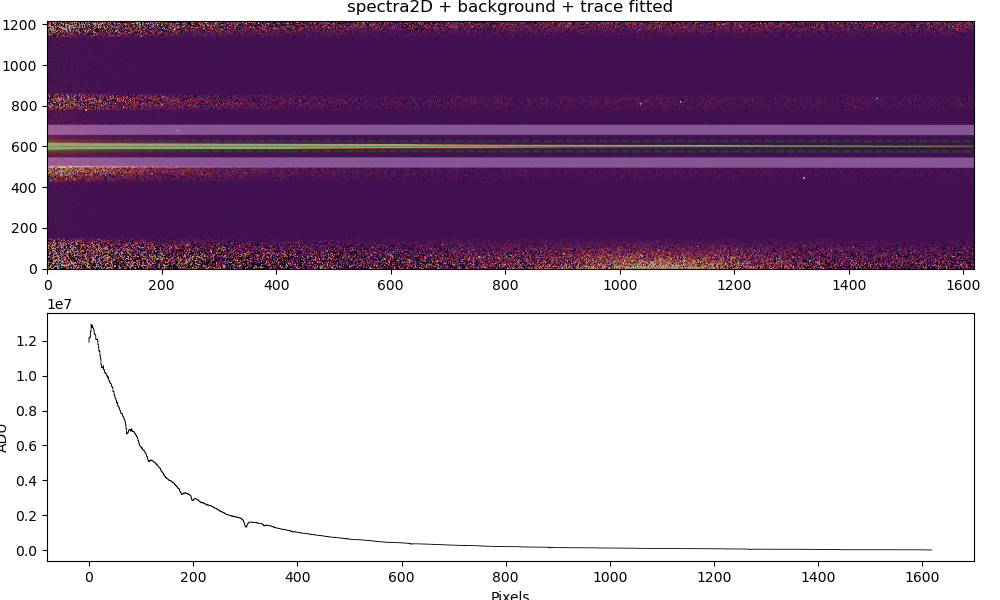

In [6]:
from astropy.modeling import models
from specreduce import tracing, background, extract

logger.info('extracting science spectra...')

master_science = CCDData.read(CAPTURE_DIR + TARGET + '-reduced.fit', unit = u.adu)
#master_science = CCDData.read(CAPTURE_DIR + TARGET + '-reduced-cosmics' + '.fit', unit = u.adu)
master_calib = CCDData.read(CAPTURE_DIR + 'mastercalib.fit', unit = u.adu)

#sci_tr = tracing.FlatTrace(master_science, 407)
sci_tr = tracing.FitTrace(master_science,  bins = 64, trace_model=models.Polynomial1D(degree=2), peak_method = 'gaussian', window = 50) 
#, guess=605) #, guess=407)

#trace_model : one of Chebyshev1D, Legendre1D, Polynomial1D, or Spline1D
#peak_method : One of gaussian, centroid, or max. gaussian
bg = background.Background.two_sided(master_science, sci_tr, separation=80, width=50) 
extract = extract.BoxcarExtract(master_science - bg, sci_tr, width = 25)
sci_spectrum = extract()

cuts = (5, 95.0)
ax0, ax1 = plt.subplots(2, 1, figsize = (10,6))[1]
plt.tight_layout()

im = ax0.imshow(master_science, origin='lower', aspect='auto', cmap=plt.cm.magma)
ax0.imshow(bg.bkg_wimage, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.3)
ax0.imshow(sci_tr.image.data, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.1)
im.set_clim(np.percentile(master_science, cuts))
ax0.step(sci_spectrum.spectral_axis, sci_tr.trace , color='g', linewidth = '0.3')
ax0.step(sci_spectrum.spectral_axis, sci_tr.trace + extract.width , color='g', linestyle='dashed', alpha=0.5)
ax0.step(sci_spectrum.spectral_axis, sci_tr.trace - extract.width , color='g', linestyle='dashed', alpha=0.5)
ax0.set_title('spectra2D + background + trace fitted')

ax1.step(sci_spectrum.spectral_axis , sci_spectrum.flux, color='black', linewidth = '0.6')
ax1.set_xlabel('Pixels')
ax1.set_ylabel('ADU')


### Extract reference spectrum

2024-08-01 18:07:35 [INFO] - extracting neon spectrum...
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-08-01 18:07:35 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


(0.0, 100000.0)

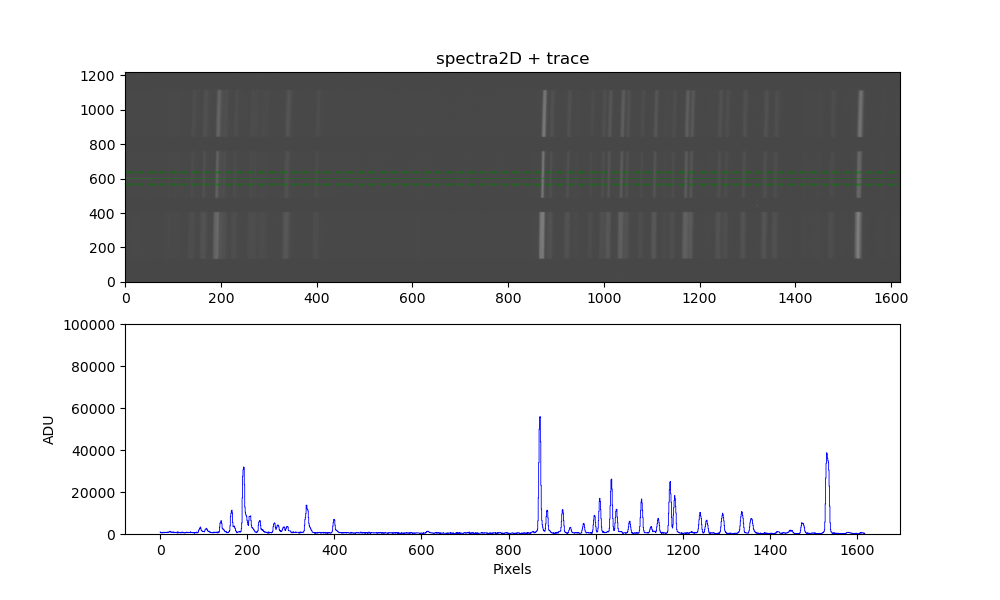

In [7]:
from astropy.modeling import models
from specreduce import tracing, background, extract

logger.info('extracting neon spectrum...')

neon_data = CCDData.read(CAPTURE_DIR + 'mastercalib.fit', unit = u.adu)

#specreduce.tracing.ArrayTrace(image: NDData, trace: ndarray)
#neon_tr = tracing.FlatTrace(neon_data,sci_tr.trace[int(sci_tr.shape[0] / 2.0)])   #FitTrace(image, peak_method='gaussian', guess=trace_pos)
#neon_tr = tracing.ArrayTrace(neon_data, sci_tr.trace[int(sci_tr.shape[0] / 2.0)])   #FitTrace(image, peak_method='gaussian', guess=trace_pos)
#bg = background.Background.two_sided(neon_data, sci_tr, separation=50, width=0) 
extract = extract.BoxcarExtract(neon_data , sci_tr, width = 35)
neon_spectrum = extract()

cuts = (5, 95.0)
ax0, ax1 = plt.subplots(2, 1, figsize = (10,6))[1]
#plt.tight_layout()

im = ax0.imshow(neon_data, origin='lower', aspect='auto', cmap=plt.cm.grey)
#ax0.imshow(bg.bkg_wimage, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.1)
ax0.imshow(sci_tr.image.data, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.1)
im.set_clim(np.percentile(master_science, cuts))
ax0.step(neon_spectrum.spectral_axis, sci_tr.trace , color='g', linewidth = '0.3')
ax0.step(neon_spectrum.spectral_axis, sci_tr.trace + extract.width , color='g', linestyle='dashed', alpha=0.5)
ax0.step(neon_spectrum.spectral_axis, sci_tr.trace - extract.width , color='g', linestyle='dashed', alpha=0.5)

ax0.set_title('spectra2D + trace')

ax1.step(neon_spectrum.spectral_axis , neon_spectrum.flux, color='blue', linewidth = '0.6')
ax1.set_xlabel('Pixels')
ax1.set_ylabel('ADU')
ax1.set_ylim(0, 0.1e6)


### Calibrate reference spectrum

2024-08-01 18:07:36 [INFO] - calibrating neon spectrum...
residuals : [ 1.16686508 -1.86925785  0.39917267  0.67215864 -0.36893854] Angstrom
fitted  Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
            c0                c1                   c2         
         Angstrom       Angstrom / pix      Angstrom / pix2   
    ----------------- ------------------ ---------------------
    4343.458795871203 1.7036962037914827 3.257487791156089e-05


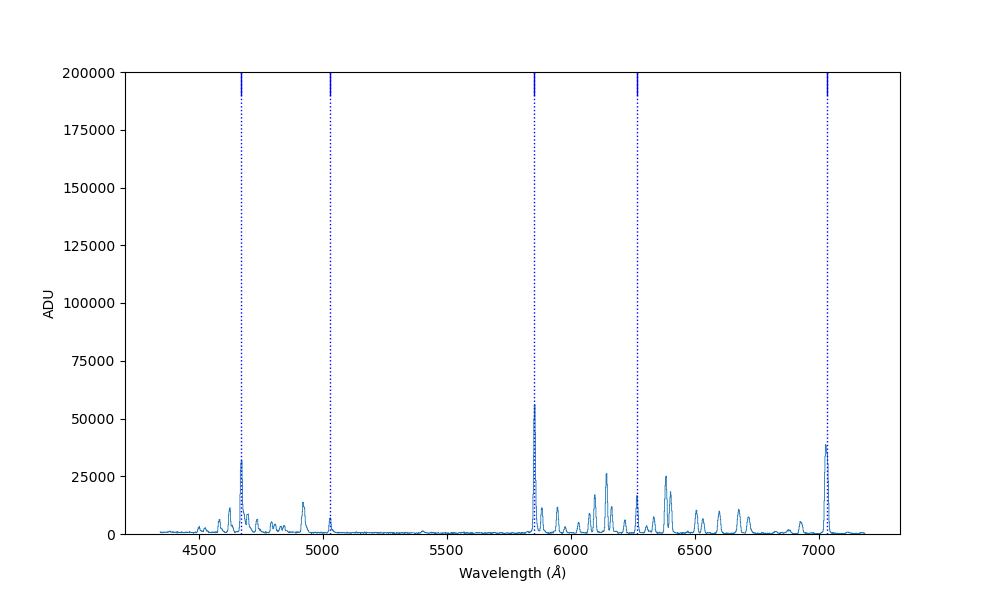

In [8]:
import astropy.units as u
from astropy.modeling import models, fitting
from specreduce import WavelengthCalibration1D

logger.info('calibrating neon spectrum...')

### alpy-600 + neon builtin
#pixels = [351, 589, 1045, 1403, 1885, 2073]*u.pix
#wavelength = [4200.67, 4764.87, 5852.49, 6677.28, 7272.94, 7635.11]*u.AA
#pixels =     [355,     1045,    1171     , 1284,   1406,      1535  , 1674  , 1840 ]*u.pix
#wavelength = [4200.67, 5852.49, 6143.06,  6402.25  , 6677.28  ,   6965.43 , 7272.94 , 7635.11]*u.AA
#wavelength_ = wavelength #= [4200.67, 5852.49, 6143.06,  6402.25  , 6677.28  ,   6965.43 , 7272.94 , 7635.11]

# Dados200 + Xenon lamp
pixels = [191, 400, 871, 1105, 1533]*u.pix
#pixels = [188, 396, 868, 1102, 1530]*u.pix
wavelength = [4671.22, 5028.28, 5852.49, 6266.49, 7031.41]*u.AA

### StarEx-2400 + neon lamp
#pixels = [868, 1276, 2342, 3635, 4263]*u.pix
#pixels = [853, 1266, 2314, 3599, 4238]*u.pix
#wavelength = [6506.53, 6532.88, 6598.95, 6678.28, 6717.04]*u.AA

### DADOS-200
#pixels = [868, 1276, 2342, 3635, 4263]*u.pix
#wavelength = [6506.53, 6532.88, 6598.95, 6678.28, 6717.04]*u.AA

#line_list = QTable([pixels, wavelength], names=["pixel_center", "wavelength"])
#input_spectrum, matched_line_list=None, line_pixels=None, line_wavelengths=None, catalog=None, input_model=Linear1D(), fitter=None
cal = WavelengthCalibration1D(input_spectrum = neon_spectrum,
      #matched_line_list = line_list,
      line_wavelengths = wavelength,
      line_pixels = pixels,
      input_model = models.Polynomial1D(degree = 2),
      #fitter = fitting.LMLSQFitter()
      fitter = fitting.LinearLSQFitter()
     )
print('residuals :', cal.residuals )
print('fitted ', cal.fitted_model )

neon_calibrated_spectrum = cal.apply_to_spectrum(neon_spectrum)

plt.figure(figsize=(10,6))
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
plt.step(neon_calibrated_spectrum.spectral_axis, neon_calibrated_spectrum.flux, linewidth = '0.6')  
for line in wavelength:
    plt.axvline(line.value, 0.95, 1.0, color = 'b', lw = 1.0)
    plt.axvline(line.value, color = 'b', lw = 1.0, linestyle = ':')
plt.ylim(0, 0.2e6);


### Apply to science spectrum

2024-08-01 18:07:36 [INFO] - calibrating science spectra...


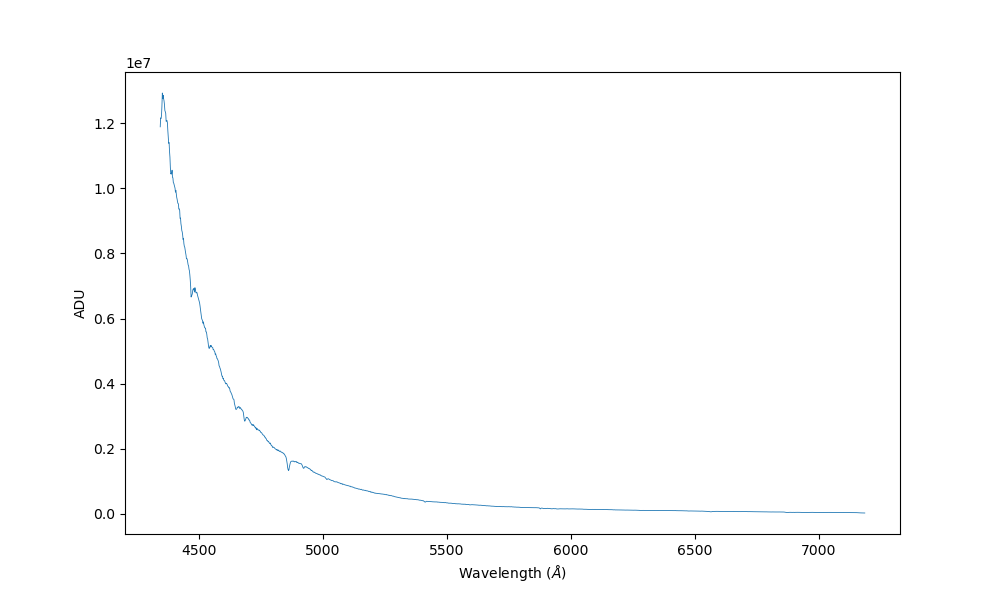

In [9]:
logger.info('calibrating science spectra...')
sci_calibrated_spectrum = cal.apply_to_spectrum(sci_spectrum)

plt.figure(figsize=(10,6))
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
plt.plot(sci_calibrated_spectrum.wavelength, sci_calibrated_spectrum.flux, linewidth = '0.6');


### Smooth spectrum (optional)

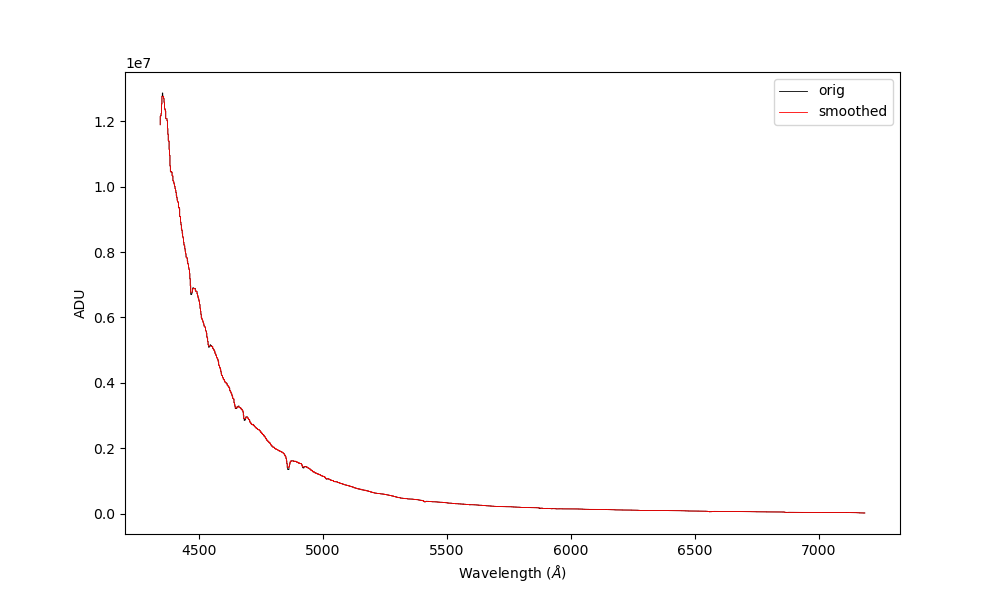

In [30]:
from specutils.manipulation import median_smooth, gaussian_smooth

smooth_spec = median_smooth(sci_calibrated_spectrum, width=7) 

plt.figure(figsize=(10,6))
#plt.xlim(3000, 9000)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
plt.step(sci_calibrated_spectrum.wavelength, sci_calibrated_spectrum.flux, color = 'black', linewidth = '0.6', label = 'orig')
plt.step(smooth_spec.wavelength, smooth_spec.flux , color = 'red', linewidth = '0.6', label = 'smoothed')
plt.legend(loc=('best'))


### decide to keep the median smoothed version ?
sci_calibrated_spectrum = smooth_spec


### Compute airmass

In [31]:
from astropy.coordinates import get_sun, AltAz, EarthLocation
from astropy.coordinates import SpectralCoord, SkyCoord
from astropy.time import Time

### compute zenith distance (if not present in fit header)
#TARGET = 'ch cyg'
target_coord = SkyCoord.from_name(TARGET)
target_time = Time(master_science.header['DATE-OBS'])
obs_coord = EarthLocation(lon = OBS_LONGITUDE * u.deg, lat = OBS_LATITUDE * u.deg)
altaz = AltAz(obstime=target_time, location = obs_coord)

ZD = target_coord.transform_to(AltAz(obstime = target_time, location = obs_coord)).zen
airmass = 1.0 / np.cos(ZD)
logger.info(f'computed ZD={ZD}, airmass={airmass}')


2024-08-01 18:16:24 [INFO] - computed ZD=39.70170336796519 deg, airmass=1.299746895222049


### Correct instrument response

2024-08-01 18:16:25 [INFO] - reusing existing response file ... 
2024-08-01 18:16:25 [INFO] - response applied


C:\Users\papa\AppData\Local\Temp\ipykernel_4704\639362200.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,6))


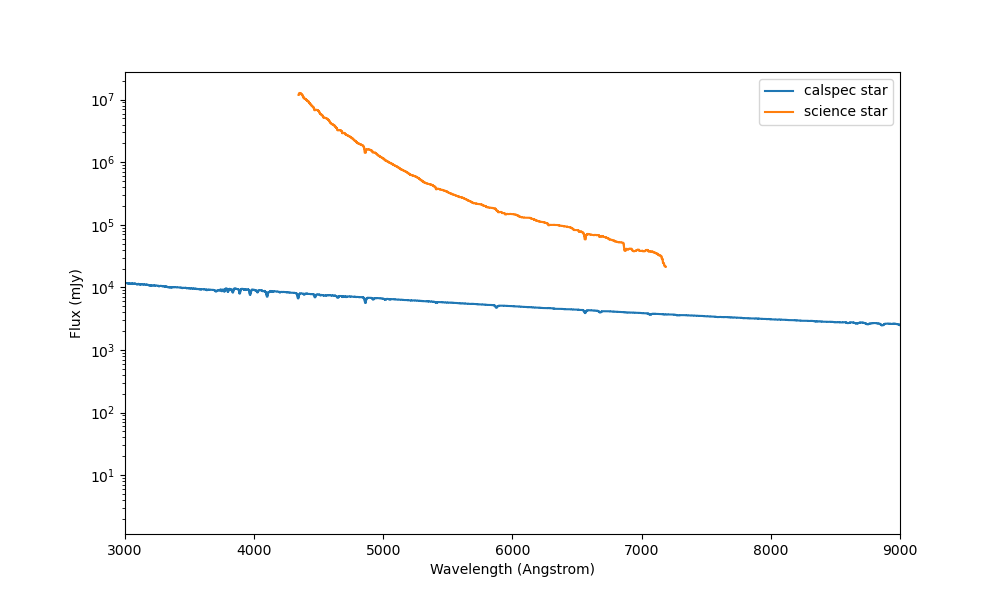

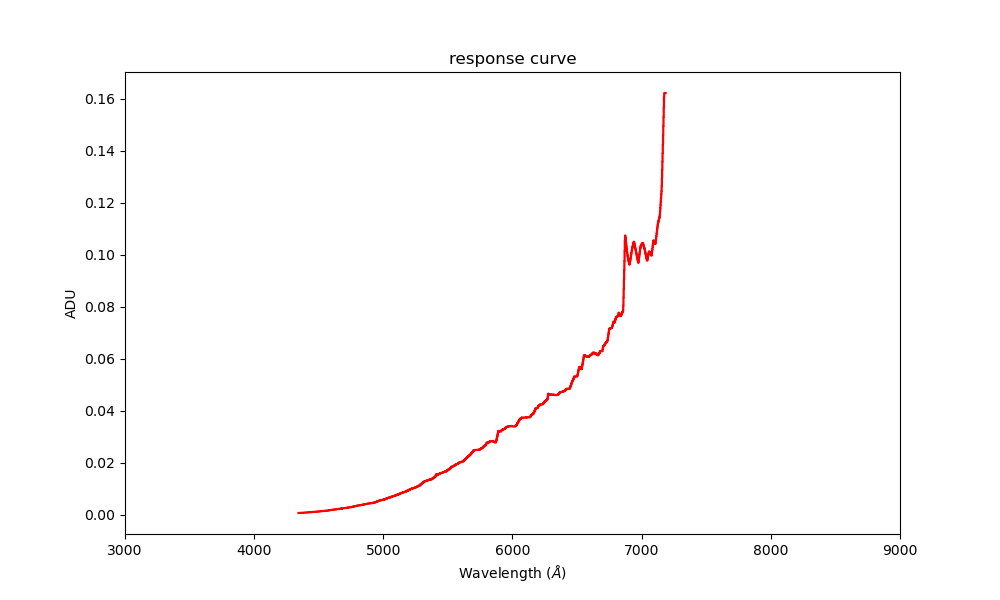

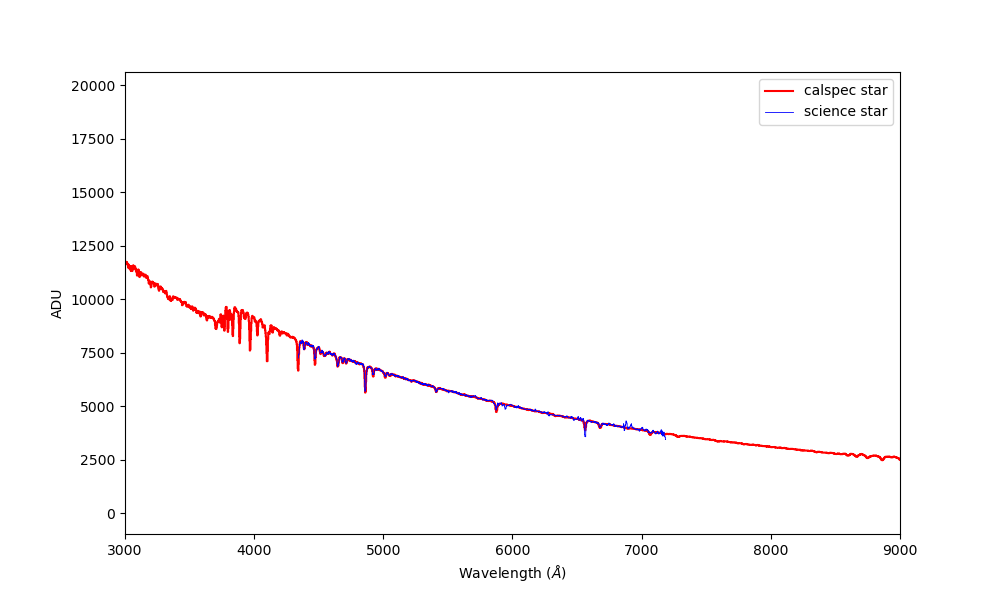

In [32]:
import matplotlib.pyplot as plt
from specreduce.calibration_data import load_MAST_calspec, load_onedstds
from specutils import Spectrum1D, SpectralRegion
from astropy.nddata import StdDevUncertainty
from specreduce.fluxcal import FluxCalibration
from specutils.manipulation import extract_region, gaussian_smooth, convolution_smooth, median_smooth
from astropy.coordinates import SpectralCoord, SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.convolution import Box1DKernel
from astropy.modeling import models, fitting
from specutils.fitting import fit_generic_continuum
import astropy.wcs as fitswcs
import astropy.io.fits as pyfits

from astropy.table import Table
from specutils.io.registers import custom_writer

### load proper reference star from CALSPEC database according to spectral type

#std_spec = load_onedstds(dataset = 'spec50cal', specfile = 'hd217086.dat')
#std_spec = load_onedstds(dataset = 'bstdscal', specfile = 'hr5511.dat')
#std_spec = load_MAST_calspec("delumi_stis_004.fits")
#std_spec = load_MAST_calspec("bd60d1753_stiswfc_004.fits")
std_spec = load_MAST_calspec("hd93521_stis_007.fits")         # O9Vp
#std_spec = load_MAST_calspec("hd101452_stis_004.fits")        # A2/3

### slice spectra (optional)
#std_slice = std_spec[3800*u.AA:8200*u.AA]
#sci_slice = sci_calibrated_spectrum[3800*u.AA:8200*u.AA]

std_slice = std_spec
sci_slice = sci_calibrated_spectrum

### show both spectra
fig, ax = plt.subplots(figsize=(10,6))

plt.xlim(3000, 9000)      # DADOS 200
#plt.xlim(6400, 6800)       # starEx2400

ax.step(std_slice.spectral_axis, std_slice.flux, label = 'calspec star') #, where="mid"
ax.step(sci_slice.spectral_axis, sci_slice.flux, label = 'science star') # where="mid", 
ax.set_yscale('log')
ax.set_xlabel(f"Wavelength ({std_slice.spectral_axis.unit})")
ax.set_ylabel(f"Flux ({std_slice.flux.unit})");
plt.legend(loc=('best'))

obj_spectrum = Spectrum1D(spectral_axis = sci_slice.spectral_axis, flux = sci_slice.flux)
sci_spectrum = FluxCalibration(obj_spectrum, airmass = airmass) 
                
### reuse response file if exists
#if False:
if os.path.exists(CAPTURE_DIR + 'masterresponse.fit'):
    logger.info('reusing existing response file ... ')
    with fits.open(CAPTURE_DIR + 'masterresponse.fit') as resp:
        specdata = resp[1].data
        header = resp[1].header
        responsefunc = Spectrum1D(flux = specdata['flux']* u.mJy, spectral_axis = specdata['wavelength'] * u.AA)
        
        final_spec = sci_spectrum.apply_sensfunc(responsefunc)
    logger.info('response applied')
else:
    logger.info('creating a new response file ...')
    responsefunc = sci_spectrum.standard_sensfunc(
        standard = std_slice,
        mode = 'linear', #'linear', # 'poly', #'spline', 
        polydeg = 3,
        #badlines=[7516, 6880, 6844, 6860, 6920, 6563, 6566, 4861, 4341],
        display = False)
    logger.info('response created')

    ### smooth the response func ?
    #smooth_response = gaussian_smooth(responsefunc, stddev=3) 
    #responsefunc = smooth_response
    #logger.info('response smoothed')
        
    final_spec = sci_spectrum.apply_sensfunc(responsefunc)
    logger.info('response applied')

    responsefunc.write(CAPTURE_DIR + 'masterresponse.fit', overwrite = True)

final_spec.write(CAPTURE_DIR + TARGET + '-1D.fit', overwrite = True)


plt.figure(figsize=(10,6))
plt.xlim(3000, 9000)      # DADOS 200
#plt.xlim(6400, 6800)       # starEx2400

plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
plt.step(responsefunc.wavelength, responsefunc.flux, linewidth = '1.6', color = 'r');
plt.title('response curve')


plt.figure(figsize=(10,6))
plt.xlim(3000, 9000)      # DADOS 200
#plt.xlim(6400, 6800)       # starEx2400

plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
#plt.step(obj_spectrum.wavelength, obj_spectrum.flux, linewidth = '0.6', color = 'black');
plt.step(std_slice.wavelength, std_slice.flux, color = 'r', label = 'calspec star') #, where="mid", 
plt.step(final_spec.wavelength, final_spec.flux, linewidth = '0.6', color = 'b', label = 'science star'); #, where="mid",
plt.legend(loc=('best'))
#plt.step(std_spec.wavelength, std_spec.flux + 5000 * u.mJy, linewidth = '0.6', color = 'r')


### Normalize & save spectrum

In [59]:
### now export science spectrum (with header from 2D science frame)
### normalize spectra to 1
#sci_mean_norm_region = final_spec[6000 * u.AA: 6200 * u.AA].flux.mean()        # DADOS200 : low resolution
sci_mean_norm_region = final_spec[6500 * u.AA: 6520 * u.AA].flux.mean()       # starEx2400 : high resolution
final_spec = Spectrum1D(spectral_axis = final_spec.wavelength, flux = final_spec.flux / sci_mean_norm_region)  

with fits.open(CAPTURE_DIR + TARGET + '-reduced.fit') as scihead:
    hdr = scihead[0].header
    del hdr['NAXIS2']
    hdr['SIMPLE']  = 'T'
    hdr['BITPIX']  = -32 
    hdr['NAXIS']   = 1 
    hdr['CRPIX1']  = 1
    #hdr['CTYPE1']  = 'Wavelength' #'Linear'
    #hdr['CUNIT1']  = 'Angstrom'
    hdr['VERSION'] = 'EasyAstro - ' + __version__  
#    hdr['BSS_TELL'] = 'None'  
#    hdr['BSS_NORM'] = 'None'  
    hdr['CRVAL1']  = 4349.2424 #final_spec.wavelength[0].value
    hdr['CDELT1']  = (final_spec.wavelength[-1].value - final_spec.wavelength[0].value) / (len(final_spec.wavelength))
    print(f'crval1={hdr["CRVAL1"]}, cdelt1={hdr["CDELT1"]}')
    hdr['OBJNAME'] = hdr['OBJECT'] 
    
    ### LEFT TO COMPUTE:
    #hdr['BSS_ITRP'] = 670
    #hdr['SPE_RPOW'] = 670
    #hdr['JD-OBS']  = '2460502.47465'
    
    fits.writeto(CAPTURE_DIR + TARGET + '-1D-final.fit', final_spec.data, header = hdr, overwrite=True)



crval1=4349.2424, cdelt1=1.7553174875950368


In [58]:
(hdr['CDELT1'])

1.7553174875950368

## Analyse spectrum

### Show known lines

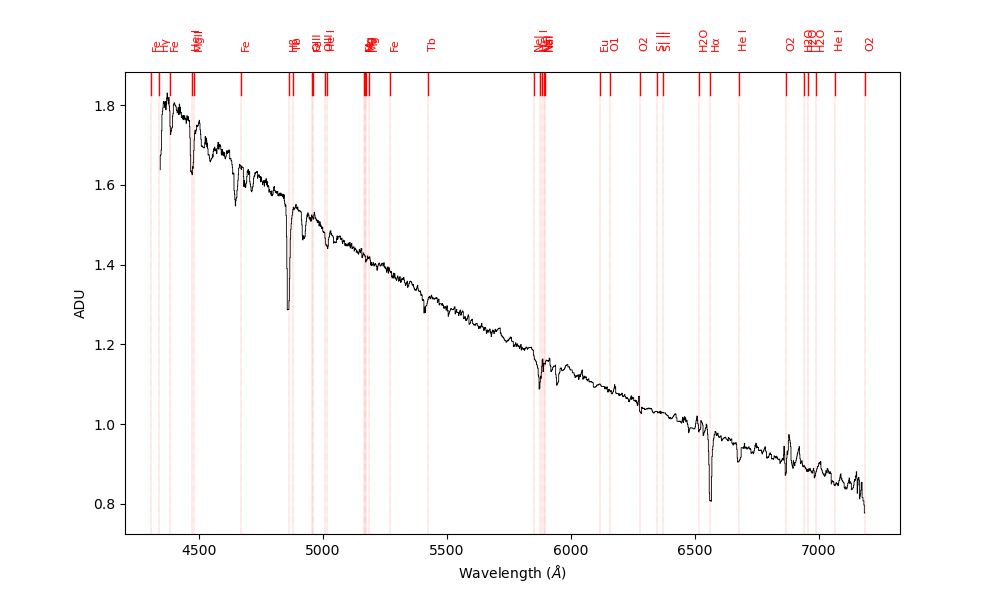

In [34]:
from spec_utils import show_lines
plt.figure(figsize = (10,6))
plt.step(final_spec.wavelength, final_spec.flux, color='black', linewidth = '0.6') #, where="mid")
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('ADU')
#plt.ylim(-10000, 1e6)

show_lines(ax = None, show_line = True)


### Measure SNR

In [15]:
from specutils.fitting import fit_generic_continuum, fit_continuum
from specutils import SpectralRegion
from astropy.modeling import models, fitting
from specutils.analysis import snr, snr_derived
from specutils import Spectrum1D
from specutils.spectra import SpectralRegion
from specutils.manipulation import extract_region

with fits.open(CAPTURE_DIR + TARGET + '-1D.fit') as file:
    specdata = file[1].data
    header = file[1].header
    final_spec1d = Spectrum1D(flux = specdata['flux'] * u.mJy, spectral_axis = specdata['wavelength'] * u.AA)

print(f'snr = {snr_derived(final_spec1d)}')

snr = 122.90142657060844


### Remove continuum

2024-08-01 18:12:48 [WARNING] - Model is linear in parameters; consider using linear fitting methods.


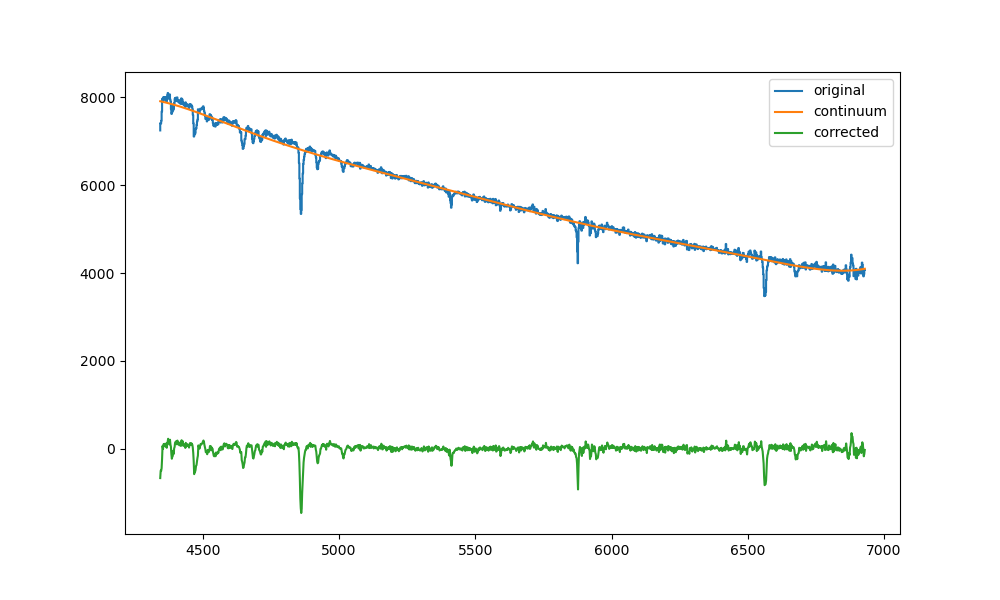

In [26]:
### extract continuum on a selected region

region = SpectralRegion(3800*u.AA, 6930*u.AA)     # low resolution
#region = SpectralRegion(6450*u.AA, 6750*u.AA)     # high resolution


sub_spectra = extract_region(final_spec1d, region)

#generic_continuum = fit_generic_continuum(sub_spectra, exclude_regions = [
        #SpectralRegion(3700 * u.AA, 4000 * u.AA),
         #SpectralRegion(4825 * u.AA, 4885 * u.AA),
         #SpectralRegion(4825 * u.AA, 5200 * u.AA),
         #SpectralRegion(6400 * u.AA, 6800 * u.AA)
        #])
generic_continuum = fit_continuum(sub_spectra, models.Hermite1D(7))

generic_continuum_evaluated = generic_continuum(sub_spectra.spectral_axis)

spec_normalized = (sub_spectra - generic_continuum_evaluated)

plt.figure(figsize = (10,6))
plt.step(sub_spectra.spectral_axis, sub_spectra.flux)
plt.plot(sub_spectra.spectral_axis, generic_continuum_evaluated)
plt.plot(spec_normalized.spectral_axis, spec_normalized.flux)
plt.legend(['original', 'continuum', 'corrected'], loc=('best'))
#plt.xlim(4700, 5000)



### Identify lines

In [28]:
### identify lines
from specutils.fitting import find_lines_derivative
from specutils.fitting import fit_lines

lines = find_lines_derivative(spec_normalized, flux_threshold=500)
print('\nemission: \n', lines[lines['line_type'] == 'emission']) 
print('\nabsorption: \n', lines[lines['line_type'] == 'absorption']) 


2024-08-01 18:13:01 [WARNING] - Spectrum is not below the threshold signal-to-noise 0.01. This may indicate you have not continuum subtracted this spectrum (or that you have but it has high SNR features).

If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning.

emission: 
 line_center line_type line_center_index
  Angstrom                             
----------- --------- -----------------

absorption: 
    line_center     line_type  line_center_index
     Angstrom                                  
------------------ ---------- -----------------
4468.0022102723715 absorption                73
 4860.946008581276 absorption               302
 5874.982073816131 absorption               884
 6561.479464238507 absorption              1271



If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


### Fit a line

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean             stddev      
           mJy             Angstrom          Angstrom     
    ----------------- ----------------- ------------------
    -753.645480218569 6563.592020491988 3.5885318470683853


(6513.0, 6613.0)

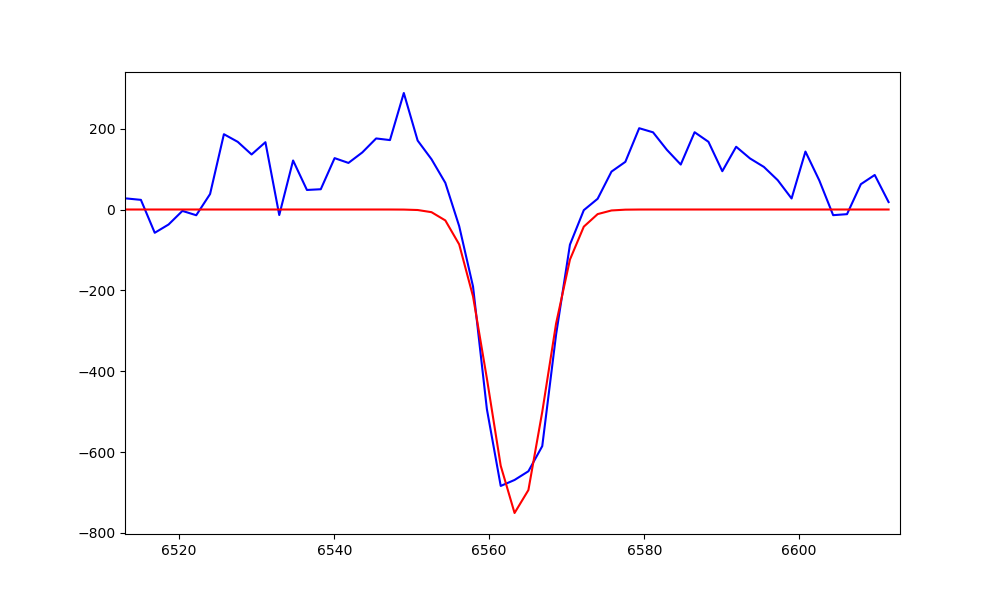

In [23]:
from specutils.manipulation import extract_region
from specutils.fitting import estimate_line_parameters
from specutils.analysis import centroid, fwhm
from specutils.fitting import fit_lines

#lineAA = 5016
lineAA = 6563
#lineAA = 4861

sr =  SpectralRegion((lineAA-50)*u.AA, (lineAA+50)*u.AA)
#sr =  SpectralRegion((lineAA-50)*u.AA, (lineAA+50)*u.AA)

#create a new spectrum of the selected region for plot
sub_spectrum = extract_region(spec_normalized, sr)
a_line = Spectrum1D(flux = sub_spectrum.flux, spectral_axis = sub_spectrum.spectral_axis)

line_estimate = models.Gaussian1D(mean = lineAA*u.AA, stddev = 5*u.AA, amplitude=45000)
line_model = fit_lines(sub_spectrum, line_estimate)
evaluated_model = line_model(sub_spectrum.wavelength)

print(line_model)

plt.figure(figsize = (10,6))
#plt.step(reg_spectra.wavelength, reg_spectra.flux, label="Original spectrum")
plt.plot(a_line.spectral_axis, a_line.flux , label="original spectrum", color = 'b')
plt.plot(a_line.spectral_axis, evaluated_model , label="Fit result", color = 'r')
#plt.plot(a_line.spectral_axis, a_line.flux)
plt.xlim(lineAA-50, lineAA+50)


### Measure line

In [19]:
### measure 
from specutils.analysis import line_flux
from specutils.analysis import equivalent_width
from specutils.analysis import gaussian_sigma_width, gaussian_fwhm, fwhm, fwzi


print(f'gaussian fwhm = {gaussian_fwhm(a_line)}' )
center = centroid(spec_normalized, sr)  
print(f'center = {center}')

print(f'fwhm = {fwhm(a_line)}') 
print(f'R = {(center / fwhm(a_line))}')
#print(f'fwzi = {fwzi(a_line)}') 

print(f'line flux = {line_flux(a_line)}'  )

#noisy_gaussian_with_continuum = noisy_gaussian + 1*u.Jy
print(f'equivalent width = {equivalent_width(a_line)}')


gaussian fwhm = 150.57781847171154 Angstrom
center = 6570.665648882164 Angstrom
fwhm = 8.014202435640073 Angstrom
R = 819.8776736237238
line flux = 1243.2467824947269 Angstrom mJy
equivalent width = -1143.2008718687737 Angstrom
